In [1]:
%load_ext autoreload
%autoreload 2

# HRRR → WindNinja Wildfire Wind Downscaling Workflow

This notebook demonstrates an end-to-end workflow for:
1. Fetching HRRR 3km wind data using Herbie
2. Visualizing the coarse wind field
3. Preparing data for WindNinja downscaling
4. Running WindNinja to get terrain-adjusted 30-100m winds
5. Visualizing the high-resolution output

## Background

**HRRR (High-Resolution Rapid Refresh)**:
- 3km horizontal resolution
- Hourly updates (most frequent operational NWP model)
- CONUS coverage
- Best operational model for fire weather applications

**WindNinja**:
- Developed by USFS Missoula Fire Sciences Lab
- Downscales NWP winds to 30-100m using mass-conserving CFD
- Accounts for terrain effects (ridges, valleys, flow channeling)
- Critical for fire behavior prediction in complex terrain

## Setup

In [2]:
import sys
sys.path.append('..')

from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from fetch_hrrr import HRRRWindFetcher
from windninja_runner import WindNinjaConfig, WindNinjaRunner, generate_slurm_script

# For nice inline plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## 1. Define Region of Interest

We'll focus on the Sierra Nevada foothills - a fire-prone region with complex terrain.

In [5]:
# Paradise/Camp Fire region (November 2018)
# REGION_NAME = "Paradise, CA (Sierra Foothills)"
# BOUNDS = (-122.0, 39.5, -121.0, 40.0)  # (west, south, east, north)

# Alternative regions you might try:
# LA Basin / Santa Ana wind corridor
REGION_NAME = "Los Angeles Basin, CA"
BOUNDS = (-118.5, 33.8, -117.5, 34.5)

# Wine Country (Tubbs Fire region)
# WINE_COUNTRY_BOUNDS = (-123.0, 38.2, -122.2, 38.8)

# Diablo wind corridor (East Bay hills)
# DIABLO_BOUNDS = (-122.3, 37.7, -121.8, 37.95)

print(f"Region: {REGION_NAME}")
print(f"Bounds: {BOUNDS}")
print(f"Approximate size: {abs(BOUNDS[2]-BOUNDS[0])*111:.0f} x {abs(BOUNDS[3]-BOUNDS[1])*111:.0f} km")

Region: Los Angeles Basin, CA
Bounds: (-118.5, 33.8, -117.5, 34.5)
Approximate size: 111 x 78 km


## 2. Fetch HRRR Surface Winds

In [6]:
fetcher = HRRRWindFetcher(cache_dir=Path("../hrrr_cache"))

# Fetch most recent available HRRR analysis (typically 2 hours behind real-time)
fetch_time = datetime.now().replace(minute=0, second=0, microsecond=0) - timedelta(hours=2)

# Fetch data from January 2025 for testing
fetch_time = datetime(2025, 1, 10, 12)

print(f"Fetching HRRR for: {fetch_time} UTC")

ds = fetcher.fetch_surface_winds(
    date=fetch_time,
    forecast_hour=0,  # 0 = analysis, 1-48 = forecasts
    bounds=BOUNDS,
)

print("\n=== Dataset Info ===")
print(ds)

INFO:fetch_hrrr:Fetching HRRR surface winds for 2025-01-10 12:00:00 F00


Fetching HRRR for: 2025-01-10 12:00:00 UTC
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local

=== Dataset Info ===
<xarray.Dataset> Size: 37kB
Dimensions:              (y: 32, x: 36)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10T12:00:00
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 10.0
    latitude             (y, x) float64 9kB 33.63 33.64 33.65 ... 34.65 34.65
    longitude            (y, x) float64 9kB 241.6 241.6 241.6 ... 242.4 242.4
    valid_time           datetime64[ns] 8B 2025-01-10T12:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    u10                  (y, x) float32 5kB -3.381 -2.881 ... -1.319 -2.569
    v10                  (y, x) float32 5kB 2.515 2.578 2.453 ... 2.265 1.203
    si10                 (y, x) float32 5kB 4.214 3.866 3.291 ... 2.621 2.836
    wdir10               (y, x) float32 5kB 126.6 131.8 138.2 

/home/topcat/projects/hrrr-wind-experiment/.venv/lib/python3.14/site-packages/cfgrib/xarray_store.py:51: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  o = xr.merge([o, ds], **kwargs)
/home/topcat/projects/hrrr-wind-experiment/.venv/lib/python3.14/site-packages/cfgrib/xarray_store.py:51: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  o 

In [7]:
# Examine the variables
print("Variables:")
for var in ds.data_vars:
    print(f"  {var}: {ds[var].attrs.get('long_name', 'N/A')} [{ds[var].attrs.get('units', 'N/A')}]")

print(f"\nGrid size: {ds.dims}")
print(f"Approximate resolution: {np.diff(ds.longitude[1].values)[0] * 111.1} km")

Variables:
  u10: 10 metre U wind component [m s**-1]
  v10: 10 metre V wind component [m s**-1]
  si10: 10 metre wind speed [m s**-1]
  wdir10: 10 metre wind direction [degree]

Grid size: FrozenMappingWarningOnValuesAccess({'y': 32, 'x': 36})
Approximate resolution: 3.4961596473700665 km


## 3. Visualize HRRR Wind Field

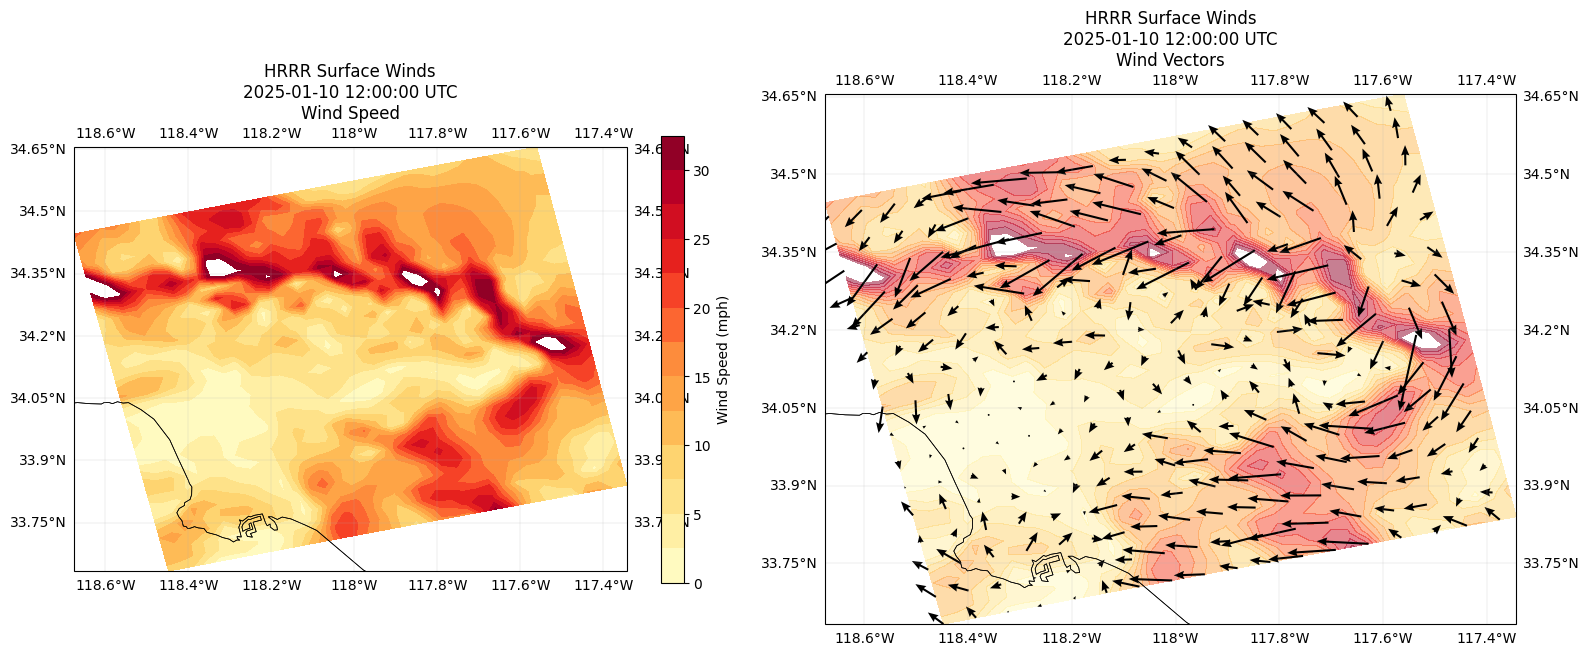

In [8]:
def plot_wind_field(ds, title="HRRR Surface Winds", skip=1):
    """
    Plot wind field with barbs or quiver arrows.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Dataset with u10/si10, v10/wdir10 or wind_speed/wind_direction
    title : str
        Plot title
    skip : int
        Plot every Nth arrow (for readability)
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Get wind components
    if 'u10' in ds:
        u = ds['u10'].values
        v = ds['v10'].values
    else:
        u = ds['u'].values
        v = ds['v'].values
    
    # Get wind speed
    if 'si10' in ds:
        speed = ds['si10'].values
    elif 'wind_speed' in ds:
        speed = ds['wind_speed'].values
    else:
        speed = np.sqrt(u**2 + v**2)
    
    # Get coordinates
    if 'longitude' in ds.coords:
        lon = ds['longitude'].values
        lat = ds['latitude'].values
    else:
        lon = ds['x'].values
        lat = ds['y'].values
    
    # Convert speed to mph for display
    speed_mph = speed * 2.237  # m/s to mph
    
    # Left panel: Wind speed contour
    ax1 = axes[0]
    cf = ax1.contourf(lon, lat, speed_mph, levels=np.arange(0, 35, 2.5),
                      cmap='YlOrRd', transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.STATES, linewidth=0.5)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
    plt.colorbar(cf, ax=ax1, label='Wind Speed (mph)', shrink=0.7)
    ax1.set_title(f'{title}\nWind Speed')
    
    # Right panel: Wind vectors
    ax2 = axes[1]
    ax2.contourf(lon, lat, speed_mph, levels=np.arange(0, 35, 2.5),
                 cmap='YlOrRd', alpha=0.5, transform=ccrs.PlateCarree())
    
    # Subsample for readability (HRRR has 2D lat/lon arrays - don't use meshgrid!)
    lon_sub = lon[::skip, ::skip]
    lat_sub = lat[::skip, ::skip]
    u_sub = u[::skip, ::skip]
    v_sub = v[::skip, ::skip]
    
    q = ax2.quiver(lon_sub, lat_sub, u_sub, v_sub,
                   transform=ccrs.PlateCarree(),
                   scale=150, width=0.003, headwidth=4)
    #ax2.quiverkey(q, 0.85, 0.02, 10, '10 m/s', labelpos='W')
    
    ax2.add_feature(cfeature.STATES, linewidth=0.5)
    ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax2.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
    ax2.set_title(f'{title}\nWind Vectors')
    
    plt.tight_layout()
    return fig

fig = plot_wind_field(ds, title=f"HRRR Surface Winds\n{fetch_time} UTC", skip=2)
plt.savefig('../output/hrrr_wind_field.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Fetch Multi-Level Winds (Optional)

For more advanced applications, we can look at winds at different pressure levels to understand vertical wind shear.

In [8]:
# Fetch winds at multiple pressure levels
ds_levels = fetcher.fetch_multilevel_winds(
    date=fetch_time,
    forecast_hour=0,
    levels=[925, 850, 700],  # Near-surface, ~1.5km, ~3km AGL
    bounds=BOUNDS,
)

print(ds_levels)

INFO:fetch_hrrr:Fetching HRRR pressure level winds for 2025-01-10 12:00:00 F00


✅ Found ┊ model=hrrr ┊ product=prs ┊ 2025-Jan-10 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


/home/topcat/projects/hrrr-wind-experiment/.venv/lib/python3.14/site-packages/herbie/core.py:978: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(search)
/home/topcat/projects/hrrr-wind-experiment/.venv/lib/python3.14/site-packages/cfgrib/xarray_store.py:51: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  o = xr.merge([o, ds], **kwargs)
/home/topcat/projects/hrrr-wind-experiment/.venv/lib/python3.14/site-packages/cfgrib/xarray_store.py:51: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_c

<xarray.Dataset> Size: 74kB
Dimensions:              (isobaricInhPa: 3, y: 32, x: 36)
Coordinates:
  * isobaricInhPa        (isobaricInhPa) float64 24B 925.0 850.0 700.0
    time                 datetime64[ns] 8B 2025-01-10T12:00:00
    step                 timedelta64[ns] 8B 00:00:00
    latitude             (y, x) float64 9kB 33.63 33.64 33.65 ... 34.65 34.65
    longitude            (y, x) float64 9kB 241.6 241.6 241.6 ... 242.4 242.4
    valid_time           datetime64[ns] 8B 2025-01-10T12:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    u                    (isobaricInhPa, y, x) float32 14kB -5.742 ... -3.86
    v                    (isobaricInhPa, y, x) float32 14kB 3.326 ... -13.01
    wind_speed           (isobaricInhPa, y, x) float32 14kB 6.635 ... 13.57
    wind_direction       (isobaricInhPa, y, x) float32 14kB 120.1 ... 16.53
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDesc

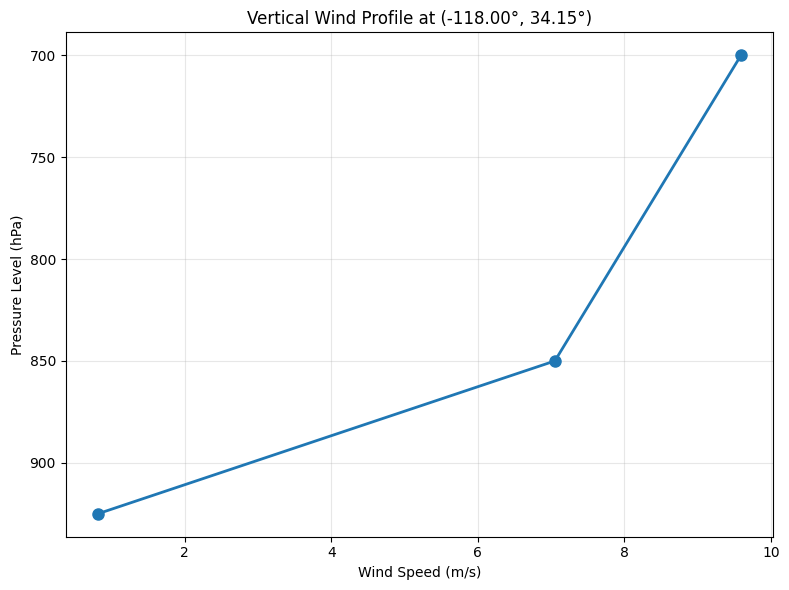

In [9]:
# Plot vertical wind profile at a point
center_lon = (BOUNDS[0] + BOUNDS[2]) / 2
center_lat = (BOUNDS[1] + BOUNDS[3]) / 2

# Convert to 0-360 if needed
if center_lon < 0:
    center_lon_360 = center_lon + 360
else:
    center_lon_360 = center_lon

fig, ax = plt.subplots(figsize=(8, 6))

# Extract wind speed at the center point for each pressure level
levels = [925, 850, 700]
wind_speeds = []

for level in levels:
    # Select data for this pressure level
    ds_level = ds_levels.sel(isobaricInhPa=level)
    
    # Find nearest point to center
    if 'longitude' in ds_level.coords:
        lon = ds_level['longitude'].values
        lat = ds_level['latitude'].values
    else:
        lon = ds_level['x'].values
        lat = ds_level['y'].values
    
    # Find closest grid point
    dist = np.sqrt((lon - center_lon_360)**2 + (lat - center_lat)**2)
    min_idx = np.unravel_index(np.argmin(dist), dist.shape)
    
    # Extract wind speed at this point
    speed = ds_level['wind_speed'].values[min_idx]
    wind_speeds.append(speed)

# Plot the profile
ax.plot(wind_speeds, levels, marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Pressure Level (hPa)')
ax.set_title(f'Vertical Wind Profile at ({center_lon:.2f}°, {center_lat:.2f}°)')
ax.invert_yaxis()  # Pressure decreases with height
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Export for WindNinja

WindNinja can be initialized in multiple ways:
1. **Domain Average**: Single wind speed/direction applied across domain
2. **Point Initialization**: From weather station observations
3. **WxModel Initialization**: From NWP model (HRRR, NAM, etc.)

For WxModel initialization, we can either:
- Use the raw GRIB2 file directly (WindNinja reads HRRR native format)
- Export to ASCII grid format for domain-average initialization

In [11]:
output_dir = Path("../output/windninja_input")
output_dir.mkdir(parents=True, exist_ok=True)

# Export to ASCII grid (for domain-average initialization)
speed_file, dir_file = fetcher.to_windninja_ascii(
    ds,
    output_dir=output_dir,
    filename_prefix=f"hrrr_{fetch_time.strftime('%Y%m%d_%H%M')}"
)

print(f"Speed file: {speed_file}")
print(f"Direction file: {dir_file}")

# Also save as NetCDF for archival
nc_file = fetcher.to_netcdf(
    ds,
    output_dir / f"hrrr_{fetch_time.strftime('%Y%m%d_%H%M')}.nc"
)
print(f"NetCDF file: {nc_file}")

INFO:fetch_hrrr:Wrote WindNinja input files: ../output/windninja_input/hrrr_20250110_1200_speed.asc, ../output/windninja_input/hrrr_20250110_1200_direction.asc
INFO:fetch_hrrr:Wrote NetCDF: ../output/windninja_input/hrrr_20250110_1200.nc


Speed file: ../output/windninja_input/hrrr_20250110_1200_speed.asc
Direction file: ../output/windninja_input/hrrr_20250110_1200_direction.asc
NetCDF file: ../output/windninja_input/hrrr_20250110_1200.nc


## 6. Prepare DEM for WindNinja

WindNinja needs a Digital Elevation Model (DEM) for terrain-adjusting winds. Options:

1. **SRTM**: ~30m global (automatic download in WindNinja)
2. **3DEP**: 10m or 1m for US (USGS)
3. **ASTER GDEM**: ~30m global alternative

For HPC runs, it's better to pre-download the DEM.

In [12]:
# Example: Download DEM using rioxarray and py3dep (optional)
# Uncomment if you have py3dep installed

import py3dep

#dem = py3dep.get_dem(BOUNDS, resolution=30)  # 30m resolution
dem_path = output_dir / "dem_30m.tif"
#dem.rio.to_raster(dem_path)
print(f"DEM saved to: {dem_path}")

DEM saved to: ../output/windninja_input/dem_30m.tif


## 7. Configure WindNinja Run

In [21]:
# Option A: Domain-average initialization (simple, fast)
# Uses mean wind from HRRR as uniform input

# Calculate domain-average wind
if 'si10' in ds:
    mean_speed = float(ds['si10'].mean().values) * 2.237  # m/s to mph
    mean_dir = float(ds['wdir10'].mean().values)
else:
    mean_speed = float(ds['wind_speed'].mean().values) * 2.237
    mean_dir = float(ds['wind_direction'].mean().values)

print(f"Domain-average wind: {mean_speed:.1f} mph from {mean_dir:.0f}°")

config_domain_avg = WindNinjaConfig(
    elevation_file=dem_path,
    output_path=Path("../output/windninja_output"),
    initialization_method="domainAverageInitialization",
    input_speed=mean_speed,
    input_speed_units="mph",
    input_direction=mean_dir,
    mesh_resolution=100.0,  # 100m output resolution
    num_threads=8,
    vegetation="brush",  # brush, grass, or trees
    write_ascii_output=True,
    write_shapefile_output=True,
)

print("\nWindNinja CLI arguments:")
for arg in config_domain_avg.to_cli_args():
    print(f"  {arg}")

Domain-average wind: 12.1 mph from 129°

WindNinja CLI arguments:
  --elevation_file=/home/topcat/projects/hrrr-wind-experiment/output/windninja_input/dem_30m.tif
  --initialization_method=domainAverageInitialization
  --mesh_resolution=100.0
  --units_mesh_resolution=m
  --output_speed_units=mph
  --output_wind_height=10.0
  --units_output_wind_height=m
  --vegetation=brush
  --num_threads=8
  --output_path=/home/topcat/projects/hrrr-wind-experiment/output/windninja_output
  --input_speed=12.073580374717713
  --input_speed_units=mph
  --input_direction=128.90321350097656
  --input_wind_height=10.0
  --units_input_wind_height=m
  --write_shapefile_output=true
  --write_ascii_output=true


In [ ]:
# Option B: HRRR model initialization (uses full spatial variability)
# Requires the raw GRIB2 file path

# The Herbie library caches GRIB2 files - find the path
from herbie import Herbie
H = Herbie(fetch_time, model="hrrr", product="sfc", fxx=0)
grib_path = H.get_localFilePath("(?:UGRD|VGRD):10 m above ground")

print(f"HRRR GRIB2 file: {grib_path}")

config_hrrr = WindNinjaConfig(
    elevation_file=dem_path,
    output_path=Path("../output/windninja_output_hrrr"),
    initialization_method="wxModelInitialization",
    wx_model_type="HRRR",
    forecast_filename=Path(grib_path) if grib_path else None,
    mesh_resolution=100.0,
    num_threads=8,
    write_ascii_output=True,
    write_shapefile_output=True,
)

print("\nWindNinja HRRR initialization CLI arguments:")
for arg in config_hrrr.to_cli_args():
    print(f"  {arg}")

## 8. Generate SLURM Script for HPC

For large domains or batch processing, run on HPC.

In [ ]:
slurm_script = generate_slurm_script(
    config_domain_avg,
    container_path=Path("./windninja.sif"),
    job_name="windninja_paradise",
    partition="standard",
    cpus_per_task=8,
    time_limit="01:00:00",
    memory="16G",
)

print(slurm_script)

# Save the script
slurm_path = Path("../output/run_windninja.slurm")
slurm_path.write_text(slurm_script)
print(f"\nSaved to: {slurm_path}")

## 9. Run WindNinja Locally (if available)

If you have WindNinja installed locally or in a container:

In [22]:
# First, test that the container is working
runner = WindNinjaRunner(container_path=Path("/home/topcat/projects/hrrr-wind-experiment/windninja.sif"))

print("Testing container setup...")
if not runner.test_container():
    print("ERROR: Container test failed!")
    print("Check that:")
    print("  1. Container file exists: /home/topcat/projects/hrrr-wind-experiment/windninja.sif")
    print("  2. Apptainer is installed: apptainer --version")
    print("  3. Container has WindNinja_cli installed")
else:
    print("✓ Container is working!\n")
    
    # Now run WindNinja with verbose output
    print("Running WindNinja with verbose output...")
    try:
        result = runner.run(config_domain_avg, verbose=True)
        print(f"\nSuccess! Output files: {result['output_files']}")
    except RuntimeError as e:
        print(f"\nWindNinja failed with error:\n{e}")
        print("\nDebug checklist:")
        print(f"  - Elevation file exists: {config_domain_avg.elevation_file.exists()}")
        print(f"  - Output directory: {config_domain_avg.output_path}")
        print(f"  - Input speed: {config_domain_avg.input_speed} {config_domain_avg.input_speed_units}")
        print(f"  - Input direction: {config_domain_avg.input_direction}°")

INFO:windninja_runner:Found: apptainer version 1.4.5
INFO:windninja_runner:Testing container with: apptainer exec /home/topcat/projects/hrrr-wind-experiment/windninja.sif WindNinja_cli --help


Testing container setup...


INFO:windninja_runner:Container test passed!
INFO:windninja_runner:Running WindNinja: apptainer exec --bind /home/topcat/projects/hrrr-wind-experiment/output/windninja_input,/home/topcat/projects/hrrr-wind-experiment/output/windninja_output /home/topcat/projects/hrrr-wind-experiment/windninja.sif WindNinja_cli --elevation_file=/home/topcat/projects/hrrr-wind-experiment/output/windninja_input/dem_30m.tif --initialization_method=domainAverageInitialization --mesh_resolution=100.0 --units_mesh_resolution=m --output_speed_units=mph --output_wind_height=10.0 --units_output_wind_height=m --vegetation=brush --num_threads=8 --output_path=/home/topcat/projects/hrrr-wind-experiment/output/windninja_output --input_speed=12.073580374717713 --input_speed_units=mph --input_direction=128.90321350097656 --input_wind_height=10.0 --units_input_wind_height=m --write_shapefile_output=true --write_ascii_output=true
INFO:windninja_runner:Elevation file: ../output/windninja_input/dem_30m.tif
INFO:windninja_r

✓ Container is working!

Running WindNinja with verbose output...


INFO:windninja_runner:WindNinja completed successfully



STDOUT:
Run 0: Reading elevation file...
Run 0: Run number 0 started with 8 threads.
Run 0: Generating mesh...
Run 0: Initializing flow...
Run 0: Building equations...
Run 0: Solving...
Run 0 (solver): 17% complete
Run 0 (solver): 36% complete
Run 0 (solver): 56% complete
Run 0 (solver): 75% complete
Run 0 (solver): 88% complete
Run 0 (solver): 96% complete
Run 0 (solver): 100% complete
Run 0: Writing output files...
Run 0: Meshing time was 0.455751 seconds.
Run 0: Initialization time was 2.285258 seconds.
Run 0: Equation building time was 12.135537 seconds.
Run 0: Solver time was 137.692533 seconds.
Run 0: Output writing time was 2.518721 seconds.
Run 0: Total simulation time was 160.408422 seconds.
Run 0: Run number 0 done!


STDERR:
(empty)


Success! Output files: [PosixPath('../output/windninja_output/dem_30m_129_12_100m.shx'), PosixPath('../output/windninja_output/dem_30m_129_12_100m.dbf'), PosixPath('../output/windninja_output/dem_30m_129_12_100m_ang.prj'), PosixPath('../output

## 10. Visualize WindNinja Output

After running WindNinja, load and visualize the high-resolution output.

In [25]:
def load_ascii_grid(filepath):
    """
    Load ESRI ASCII grid file into xarray DataArray.
    """
    with open(filepath) as f:
        # Parse header
        header = {}
        for _ in range(6):
            line = f.readline().split()
            header[line[0].lower()] = float(line[1])
        
        # Read data
        data = np.loadtxt(f)
    
    # Create coordinates
    ncols = int(header['ncols'])
    nrows = int(header['nrows'])
    xll = header['xllcorner']
    yll = header['yllcorner']
    cellsize = header['cellsize']
    nodata = header.get('nodata_value', -9999)
    
    # Replace nodata with NaN
    data[data == nodata] = np.nan
    
    # Flip data (ASCII is stored top-to-bottom)
    data = np.flipud(data)
    
    # Create coordinate arrays
    x = np.arange(xll, xll + ncols * cellsize, cellsize)[:ncols]
    y = np.arange(yll, yll + nrows * cellsize, cellsize)[:nrows]
    
    da = xr.DataArray(
        data,
        dims=['y', 'x'],
        coords={'y': y, 'x': x}
    )
    return da

# Example: Load WindNinja output (when available)
wn_speed = load_ascii_grid("../output/windninja_output/dem_30m_129_12_100m_vel.asc")
wn_dir = load_ascii_grid("../output/windninja_output/dem_30m_129_12_100m_ang.asc")

Comparison plot skipped (no WindNinja output yet)


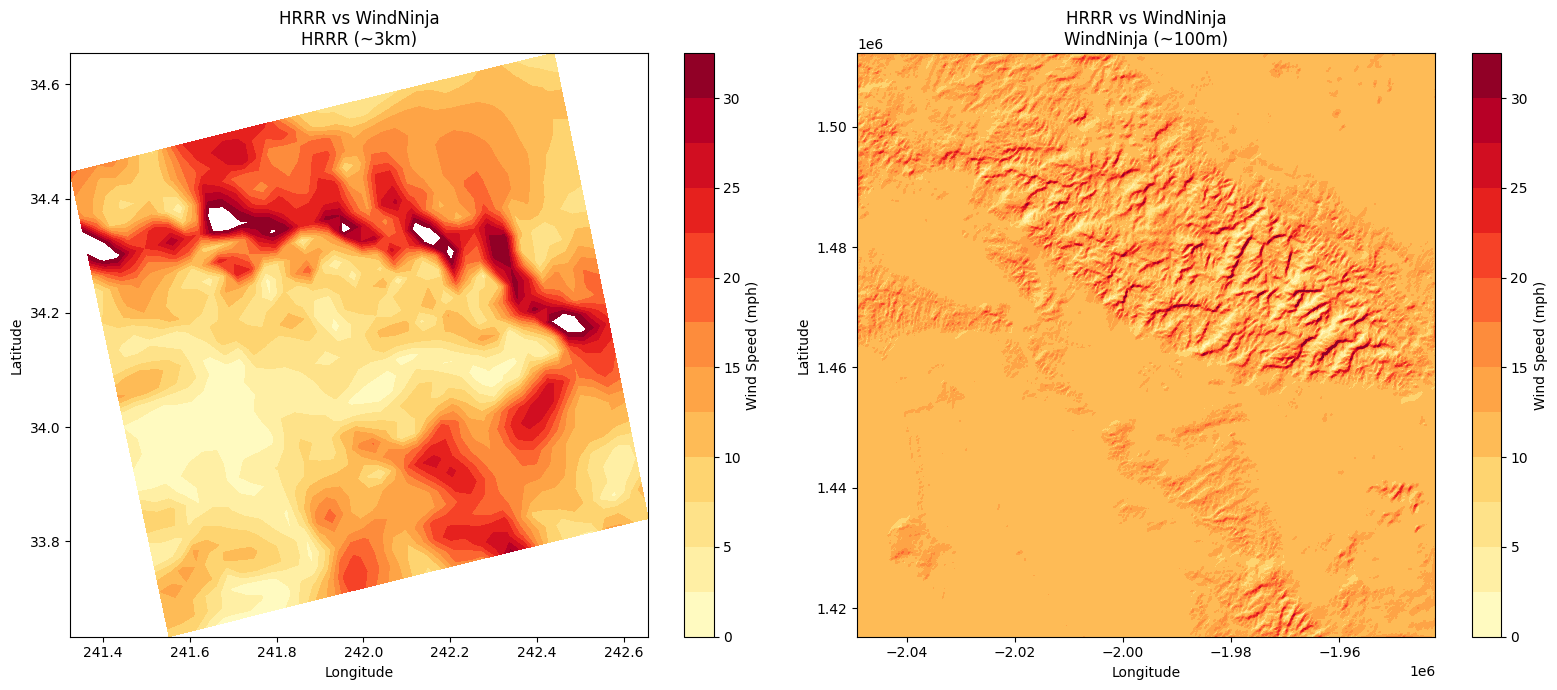

In [27]:
def compare_hrrr_windninja(hrrr_ds, wn_speed, wn_dir, title="HRRR vs WindNinja"):
    """
    Side-by-side comparison of HRRR and WindNinja wind fields.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # HRRR (left)
    ax1 = axes[0]
    if 'si10' in hrrr_ds:
        speed = hrrr_ds['si10'].values * 2.237  # m/s to mph
    else:
        speed = hrrr_ds['wind_speed'].values * 2.237
    
    if 'longitude' in hrrr_ds.coords:
        lon, lat = hrrr_ds['longitude'].values, hrrr_ds['latitude'].values
    else:
        lon, lat = hrrr_ds['x'].values, hrrr_ds['y'].values
    
    cf1 = ax1.contourf(lon, lat, speed, levels=np.arange(0, 35, 2.5), cmap='YlOrRd')
    plt.colorbar(cf1, ax=ax1, label='Wind Speed (mph)')
    ax1.set_title(f'{title}\nHRRR (~3km)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    # WindNinja (right)
    ax2 = axes[1]
    cf2 = ax2.contourf(wn_speed.x, wn_speed.y, wn_speed.values, 
                       levels=np.arange(0, 35, 2.5), cmap='YlOrRd')
    plt.colorbar(cf2, ax=ax2, label='Wind Speed (mph)')
    ax2.set_title(f'{title}\nWindNinja (~100m)')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    
    plt.tight_layout()
    return fig

# Uncomment when WindNinja output is available:
fig = compare_hrrr_windninja(ds, wn_speed, wn_dir)
plt.savefig('../output/hrrr_vs_windninja.png', dpi=150, bbox_inches='tight')

print("Comparison plot skipped (no WindNinja output yet)")

## 11. Time Series Animation (Advanced)

For forecasting applications, fetch a time series and animate.

In [ ]:
# Fetch 6-hour time series
# start_time = fetch_time
# end_time = fetch_time + timedelta(hours=6)
# 
# ds_timeseries = fetcher.fetch_time_series(
#     start_date=start_time,
#     end_date=end_time,
#     bounds=BOUNDS,
#     hours_interval=1,
# )
# 
# print(ds_timeseries)

print("Time series fetch skipped (can be slow)")
print("Uncomment the code above to fetch 6 hours of HRRR data")

## Summary

This notebook demonstrated:

1. **HRRR Data Access**: Using Herbie to fetch operational 3km wind data
2. **Visualization**: Wind speed contours and quiver plots with Cartopy
3. **Export**: Converting to WindNinja-compatible formats (ASCII, NetCDF)
4. **WindNinja Config**: Setting up both domain-average and model initialization
5. **HPC Integration**: Generating SLURM scripts for batch processing

### Next Steps

1. **Download real DEM**: Use `py3dep` or USGS 3DEP for actual elevation data
2. **Pull WindNinja container**: `apptainer pull windninja.sif docker://firelab/windninja:latest`
3. **Run WindNinja**: Either locally or on HPC
4. **Validation**: Compare WindNinja output against RAWS observations
5. **Integration**: Feed into fire behavior models (FARSITE, FlamMap, etc.)